# Setup

(Use environment lostarling)

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from joblib import Parallel,delayed
import datetime
import copy
import sys
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
# sys.path.append('/mnt/cube/tsmcpher/proj/am_pop/code') ## lots of MNE code in here
from ceciestunepipe.util import h5util as h5u
from ceciestunepipe.util.sound import spectral as sp

sys.path.append('/mnt/cube/lo/envs/vocalization-segmentation')
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation, plot_segmented_spec, plot_segmentations
sys.path.append('/mnt/cube/lo/envs/avgn_paper')
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.utils.hparams import HParams
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram, flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.projections import scatter_spec
import umap
import hdbscan

<ipython-input-1-5fc999edf1c5>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [3]:
bout_h5_path = '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_df_gpfa.h5'
output_path = '/mnt/cube/lo/test/s_b1555_22/ra_sort_2022-04-29/'
proc_data_dict_file = os.path.join(output_path, 'proc_data_dict.pkl')
bout_h5_path, proc_data_dict_file, output_path

('/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_df_gpfa.h5',
 '/mnt/cube/lo/test/s_b1555_22/ra_sort_2022-04-29/proc_data_dict.pkl',
 '/mnt/cube/lo/test/s_b1555_22/ra_sort_2022-04-29/')

# Load data

In [4]:
bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr','spk_ms_arr'])

In [5]:
## sort longest-to-shortest bout
bout_df.sort_values(['len_ms'], ascending=False, inplace=True, ignore_index=False)
# bout_df['song_type'] = 'stim'
# bout_df['song_type'][bout_df['stim_name'].isna()] = 'bout'
# bout_df['spk_arr'].fillna(0, inplace=True)

## remove bouts under 7s
bout_sel = bout_df['len_ms'] < 7000
print(str(len(bout_sel))+' rows in bout_df, '+str(np.sum(bout_sel))+' bouts under 7s')
bout_df.drop(index=bout_df[bout_sel].index, inplace=True)
bout_df.reset_index(inplace=True, drop=True)

90 rows in bout_df, 38 bouts under 7s


In [6]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_gpf',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx'],
      dtype='object')

In [7]:
bout_dict['s_f_gpf'] = 1/(0.001 * bout_dict['gpfa_bin_ms'])

In [8]:
bout_dict

{'gpfa_bin_ms': 15,
 'gpfa_xdim': 8,
 's_f': 40000,
 's_f_ap_0': 30000.02776121381,
 's_f_nidq': 39999.39190353144,
 't_post': 5,
 't_pre': -5,
 's_f_gpf': 66.66666666666667}

In [9]:
bout_df.head(2)

index                                               f_xx  \
0      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
1      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   

                                             mic_arr  \
0  [-26, -31, -50, -30, -42, -46, -16, -42, -33, ...   
1  [-15, -26, -20, -42, -25, -25, -33, -21, -18, ...   

                                             pre_arr  \
0  [10837, 10844, 10825, 10821, 10834, 10833, 108...   
1  [10815, 10802, 10812, 10848, 10821, 10818, 108...   

                                            pre_filt  \
0  [10836.60446304681, 10835.625539382952, 10834....   
1  [10814.791321144921, 10815.459500210565, 10816...   

                                                s_xx  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                             spk_gpf  \
0  [[0.33551924558719, 0.36238272663092347, 0.413...   
1  [[0.025640486322789882, 0.06350922925429851, 0...   

                                              sxx_pc  \
0  [[-8.162334, 1.087682, 0.63549316], [-8.162334...   
1  [[-8.162334, 1.087682, 0.63549316], [-8.162334...   

                                              syl_in  \
0  [[5768678, 5768773], [5768798, 5769313], [5769...   
1  [[6702913, 6702988], [6703083, 6703163], [6704...   

                                                t_xx  ... end_sample_ap_0  \
0  [0.0064, 0.0074, 0.0084, 0.0094, 0.0104, 0.011...  ...       174929413   
1  [0.0064, 0.0074, 0.0084, 0.0094, 0.0104, 0.011...  ...       202764016   

                                                file len_ms len_sample_ap_0  \
0  /mnt/sphere/speech_bci/derived_data/s_b1555_22...  62210         1866301   
1  /mnt/sphere/speech_bci/derived_data/s_b1555_22...  55780         1673401   

  start_ms   start_ms_ap_0 start_sample start_sample_ap_0 start_sample_naive  \
0  5768678  5768765.053336    230747120         173063112          230747120   
1  6702913  6703014.271991    268116520         201090615          268116520   

  bout_idx  
0        0  
1        1  

[2 rows x 24 columns]

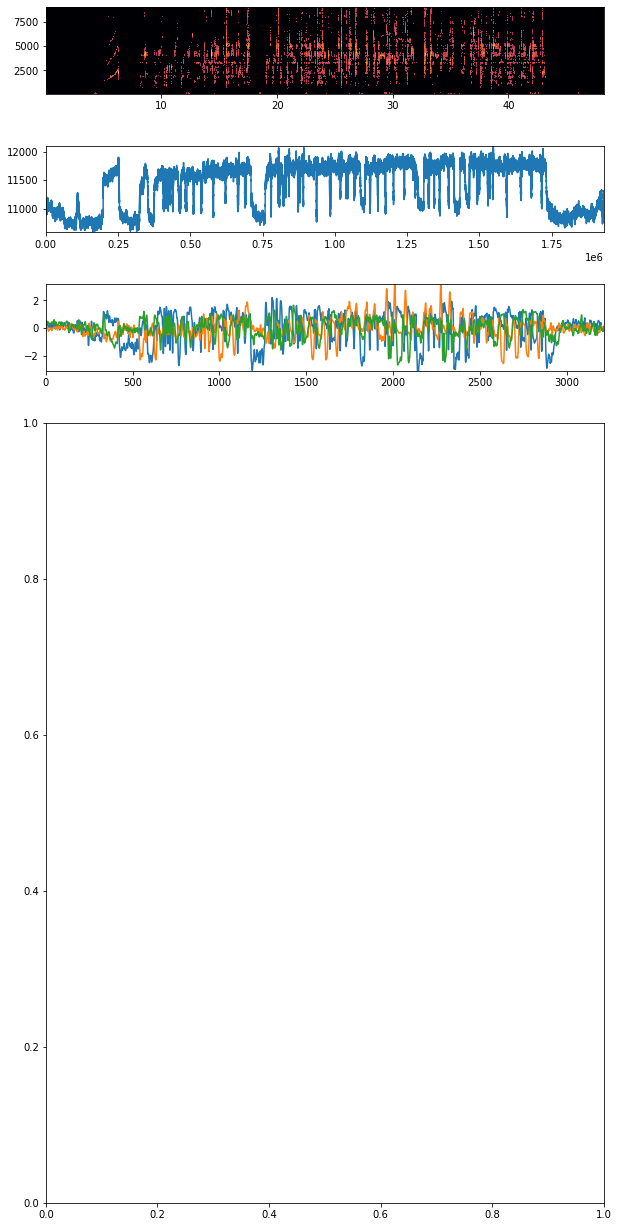

In [10]:
def plot_bout(bout_series, bout_dict, plot_raster=False):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    gpf_arr = bout_series['spk_gpf']
    
    # plot
    
    fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 1, 9]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    ax[2].plot(gpf_arr[:3].T)
    
    
    if plot_raster:
        spk_arr = bout_series['spk_arr']
        pu.plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[2])
    
plot_bout(bout_df.iloc[11], bout_dict, plot_raster = False)

## Segment each bout

In [12]:
min_level_db = -120 ## default dB minimum of spectrogram (threshold anything below)
min_level_db_floor = -40 ## highest number min_level_db is allowed to reach dynamically
db_delta = 5 ## delta in setting min_level_db
n_fft = 512 ## FFT window size
hop_length_ms = 1 ## number audio of frames in ms between STFT columns
win_length_ms = 5 ## size of fft window (ms)
ref_level_db = 20 ## reference level dB of audio
pre = 0.97 ## coefficient for preemphasis filter
spectrogram_range = None ## spectral range to care about for spectrogram
verbose = True ## display output
mask_thresh_std = 0.8 ## standard deviations above median to threshold out noise (higher = threshold more noise)
neighborhood_time_ms = 50 ## size in time of neighborhood-continuity filter
neighborhood_freq_hz = 500 ## size in Hz of neighborhood-continuity filter
neighborhood_thresh = 0.75 ## threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
min_syllable_length_s = 0.05 ## shortest expected length of syllable
min_silence_for_spec = 0.1 ## shortest expected length of silence in a song (used to set dynamic threshold)
silence_threshold = 0.015#0.015 ## threshold for spectrogram to consider noise as silence
max_vocal_for_spec = 2.0 ## longest expected vocalization in seconds
temporal_neighbor_merge_distance_ms = 50 ##longest distance at which two elements should be considered one
overlapping_element_merge_thresh = np.inf ##proportion of temporal overlap to consider two elements one
min_element_size_ms_hz = [0,0] ## smallest expected element size (in ms and Hz). Everything smaller is removed
butter_min = 500
butter_max = 7500
figsize = (20,5)

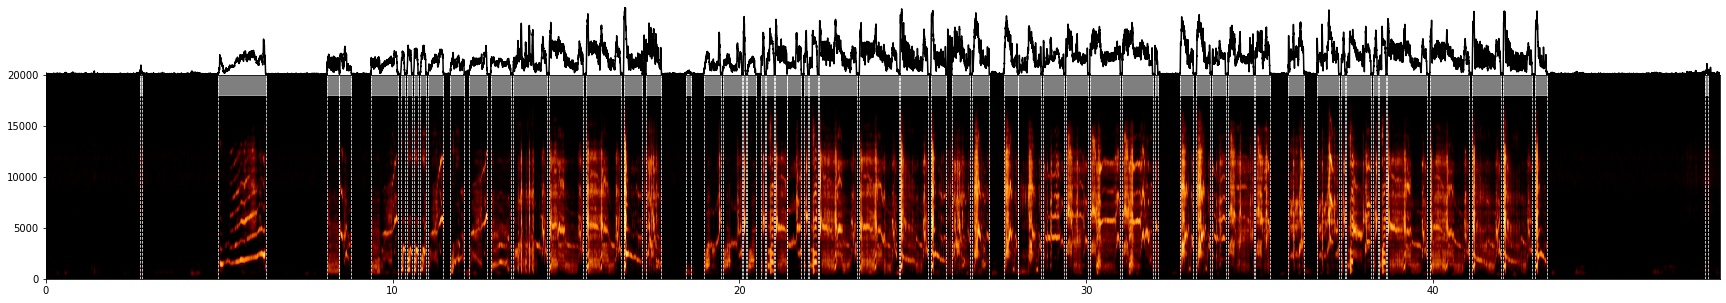

CPU times: user 5.12 s, sys: 585 ms, total: 5.71 s
Wall time: 5.81 s


(-0.5086779661016951, 0.3279147491877217)

In [13]:
%%time
def segment_bout(x_int: np.array, bout_dict, plot: bool=True) -> dict:
    x = x_int.astype(float)/np.max(np.abs(x_int))
    
    #x = int16_to_float32(x_int)
    
    x = butter_bandpass_filter(x, butter_min, butter_max, bout_dict['s_f'])
    
    x_segmented = dynamic_threshold_segmentation(x, bout_dict['s_f'],
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    
    if plot and x_segmented:
        plot_segmentations(
            x_segmented["spec"],
            x_segmented["vocal_envelope"],
            x_segmented["onsets"],
            x_segmented["offsets"],
            hop_length_ms,
            bout_dict['s_f'],
        )
        plt.show()
    return x_segmented['onsets'], x_segmented['offsets']

on, off = segment_bout(bout_df.iloc[11]['mic_arr'].flatten(), bout_dict)
np.mean(on - off),np.std(on-off)

In [14]:
def segment_series(ds: pd.Series) -> dict:
    on_sec,  off_sec = segment_bout(ds['mic_arr'].flatten(), bout_dict, plot=False)
    on = (on_sec * bout_dict['s_f']).astype(int)
    off = (off_sec * bout_dict['s_f']).astype(int)
    return on, off

seg_ser_dict = segment_series(bout_df.iloc[11])

In [15]:
%%time
tqdm.pandas(desc='segment bouts')
bout_df[['s_on', 's_off']] = bout_df.progress_apply(segment_series, axis=1, result_type='expand')

onset_sec = 0.1 #100ms preceding each syllable
bout_df['s_on'] = bout_df['s_on'] - int(onset_sec*bout_dict['s_f'])

bout_df['s_on_ap'] = bout_df['s_on'].apply(lambda x: (x *bout_dict['s_f_ap_0']/bout_dict['s_f_nidq']).astype(int))
bout_df['s_off_ap'] = bout_df['s_off'].apply(lambda x: (x *bout_dict['s_f_ap_0']/bout_dict['s_f_nidq']).astype(int))

#bout_df['gp_nidq_rate'] = bout_df['spk_gpf'].apply(lambda x: x.shape[-1]) / bout_df['mic_arr'].apply(lambda x: x.size)
bout_df['gp_nidq_rate'] = bout_dict['s_f_gpf'] / (bout_dict['s_f'])
bout_df['gp_nidq_rate'] = bout_dict['s_f_gpf'] / (bout_dict['s_f'])

bout_df['ms_on'] = bout_df['s_on'] * 1000 / bout_dict['s_f_nidq'] 
bout_df['ms_off'] = bout_df['s_off'] * 1000 / bout_dict['s_f_nidq'] 

segment bouts:   0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 3min 11s, sys: 22.1 s, total: 3min 33s
Wall time: 3min 33s


In [16]:
### get the spectrograms for all syllables
def get_syl_df(ds: pd.Series, spk=False) -> pd.DataFrame:
    syl_idx = ['{}-{}'.format(ds['bout_idx'], i) for i in range(ds['s_on'].size)]
    syl_x = [ds['mic_arr'][int(on): int(off)] for on, off in zip(ds['s_on'], ds['s_off'])]
    syl_pre = [ds['pre_arr'][int(on): int(off)] for on, off in zip(ds['s_on'], ds['s_off'])]
    
    f = ds['gp_nidq_rate']
    syl_gpf_arr = [ds['spk_gpf'].T[int(on*f): int(off*f)].T for on, off in zip(ds['s_on'], ds['s_off'])]
    
    # get spikes and format to ms scale
    ap_ms_bin = int(0.001 * bout_dict['s_f_ap_0'])
    
    if spk:
        syl_spk_arr_ms = [pu.coarse(ds['spk_arr'].T[int(on): int(off)].T, ap_ms_bin) for on, off in zip(ds['s_on_ap'], ds['s_off_ap'])]
        syl_spk_arr = [ds['spk_arr'][:, int(on): int(off)] for on, off in zip(ds['s_on_ap'], ds['s_off_ap'])]
    else:
        syl_spk_arr_ms = np.nan
        syl_spk_arr = np.nan
        
    syl_df = pd.DataFrame({'syl_idx': syl_idx,
                          'mic_arr': syl_x,
                          's_on': ds['s_on'],
                           's_on_gpf': (ds['s_on']*f).astype(int),
                           'gpf_arr': syl_gpf_arr,
                          'pre_arr': syl_pre,
                           'spk_ms_arr': syl_spk_arr_ms,
                           'spk_arr': syl_spk_arr,
                          'bout_idx': ds['bout_idx']})
    return syl_df

sdf = get_syl_df(bout_df.iloc[3])

In [17]:
syl_df = pd.concat([get_syl_df(ds) for i, ds in bout_df.iterrows()], axis=0)
syl_df.reset_index(inplace=True, drop=True)

In [18]:
syl_df.head(1)

syl_idx                                            mic_arr    s_on  \
0     0-0  [2, 3, 11, 4, -1, 13, 32, -8, 15, -4, 18, 11, ...  189640   

   s_on_gpf                                            gpf_arr  \
0       316  [[-0.7721941002898705, -0.654150502280424, -0....   

                                             pre_arr  spk_ms_arr  spk_arr  \
0  [10913, 10921, 10909, 10908, 10926, 10917, 109...         NaN      NaN   

  bout_idx  
0        0

In [19]:
# some syllables start right near the edge, and with the onset_sec parameter can start in negative indexes. 
# for now, just get rid of those
syl_df = syl_df[syl_df['s_on']>0]
syl_df.reset_index(inplace=True, drop=True)

#### get all spectrograms

In [20]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 1,
    nex=-1,
    n_jobs=-1,
    verbosity = 0,
) ## from Tim

mel_matrix = prepare_mel_matrix(hparams, bout_dict['s_f'])

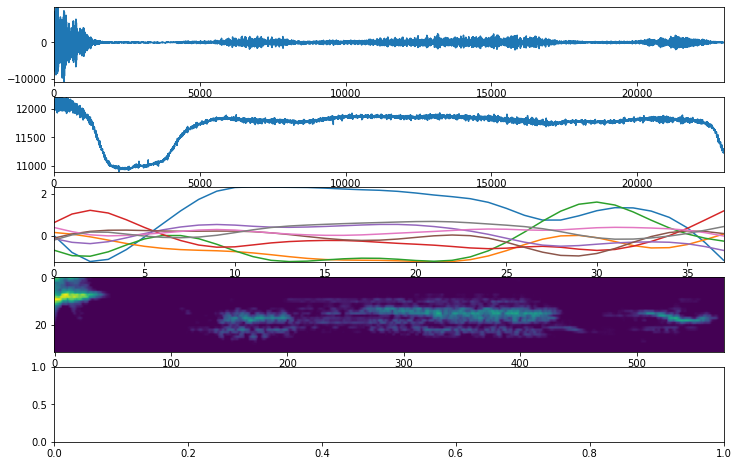

In [21]:
i_syl = 11
one_spec = make_spec(syl_df.iloc[i_syl]['mic_arr']/32768, bout_dict['s_f'],
                    hparams=hparams,
                    mel_matrix=mel_matrix,
                    use_mel=True,
                    use_tensorflow=False)

fig, ax = plt.subplots(nrows=5, figsize=(12, 8))

ax[0].plot(syl_df.iloc[i_syl]['mic_arr'])
ax[1].plot(syl_df.iloc[i_syl]['pre_arr'])
ax[2].plot(syl_df.iloc[i_syl]['gpf_arr'].T);
ax[3].imshow(one_spec[::-1], aspect='auto')
#pu.plot_as_raster(syl_df.iloc[i_syl]['spk_ms_arr'], ax[4])

In [22]:
%%time
tqdm.pandas(desc='making spectrograms')
syl_df['spec'] = syl_df['mic_arr'].progress_apply(lambda x: make_spec(x/32768, bout_dict['s_f'], 
                                                                 hparams=hparams,
                                                                 mel_matrix=mel_matrix,
                                                                 use_mel=True,
                                                                 use_tensorflow=False))

making spectrograms:   0%|          | 0/2169 [00:00<?, ?it/s]

CPU times: user 8min 8s, sys: 11.6 s, total: 8min 20s
Wall time: 31.5 s


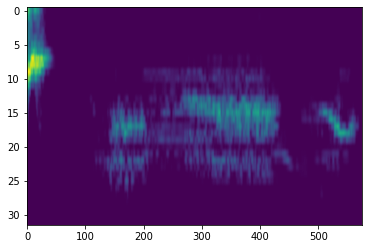

In [23]:
one_spec = syl_df.iloc[i_syl]['spec']
plt.imshow(one_spec[::-1], aspect='auto')

### pad spectrogams

In [24]:
all_syl_len = [s.shape[-1] for s in syl_df['spec']]
pad_len = np.max(all_syl_len)

syl_df['spec_pad'] = syl_df['spec'].apply(lambda x: pad_spectrogram(x, pad_len))

In [25]:
pre_pad_len = np.max(list(map(lambda x: x.shape[-1], syl_df['pre_arr'])))
pre_pad_len

syl_df['pre_pad'] = syl_df['pre_arr'].apply(lambda x: pad_spectrogram(np.expand_dims(x-np.min(x), 
                                                                                     axis=0), 
                                                                      pre_pad_len).flatten())

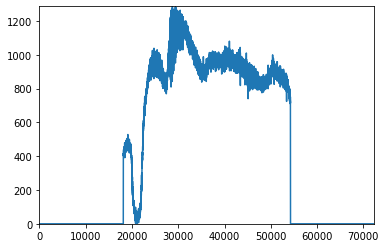

In [26]:
one_pre = syl_df.iloc[1]['pre_pad']
plt.plot(one_pre)

In [27]:
gpfa_pad_len = np.max(list(map(lambda x: x.shape[-1], syl_df['gpf_arr'])))
gpfa_pad_len

syl_df['gpf_pad'] = syl_df['gpf_arr'].apply(lambda x: pad_spectrogram(x, gpfa_pad_len))

In [27]:
# spk_pad_len = np.max(list(map(lambda x: x.shape[-1], syl_df['spk_ms_arr'])))
# spk_pad_len

# syl_df['spk_pad'] = syl_df['spk_ms_arr'].apply(lambda x: pad_spectrogram(x, spk_pad_len))

In [28]:
#spk_pad = pad_spectrogram(syl_df.iloc[i_syl]['spk_ms_arr'], spk_pad_len)

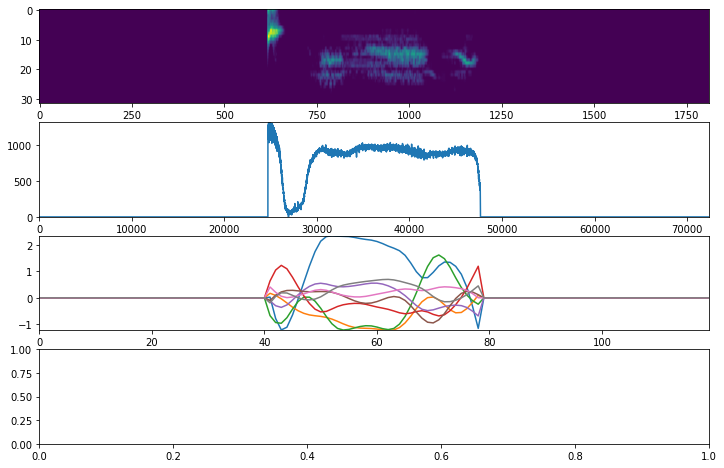

In [28]:
i_syl=11

def plot_syl(syl_df, i_syl, spk=False):
    fig, ax = plt.subplots(nrows=4, figsize=(12, 8))

    ax[0].imshow(syl_df.iloc[i_syl]['spec_pad'][::-1], aspect='auto')
    ax[1].plot(syl_df.iloc[i_syl]['pre_pad'])
    ax[2].plot(syl_df.iloc[i_syl]['gpf_pad'].T);
    if spk:
        pu.plot_as_raster(syl_df.iloc[i_syl]['spk_pad'], ax[3])
        ax[3].set_xlim(0, syl_df.iloc[i_syl]['spk_pad'].shape[-1])
    return ax, syl_df.iloc[i_syl]

ax, syl_ds = plot_syl(syl_df, i_syl)

In [29]:
syl_df['spec_pad'] = syl_df['spec_pad'].apply(lambda x: (norm(x)*255).astype('uint8'))

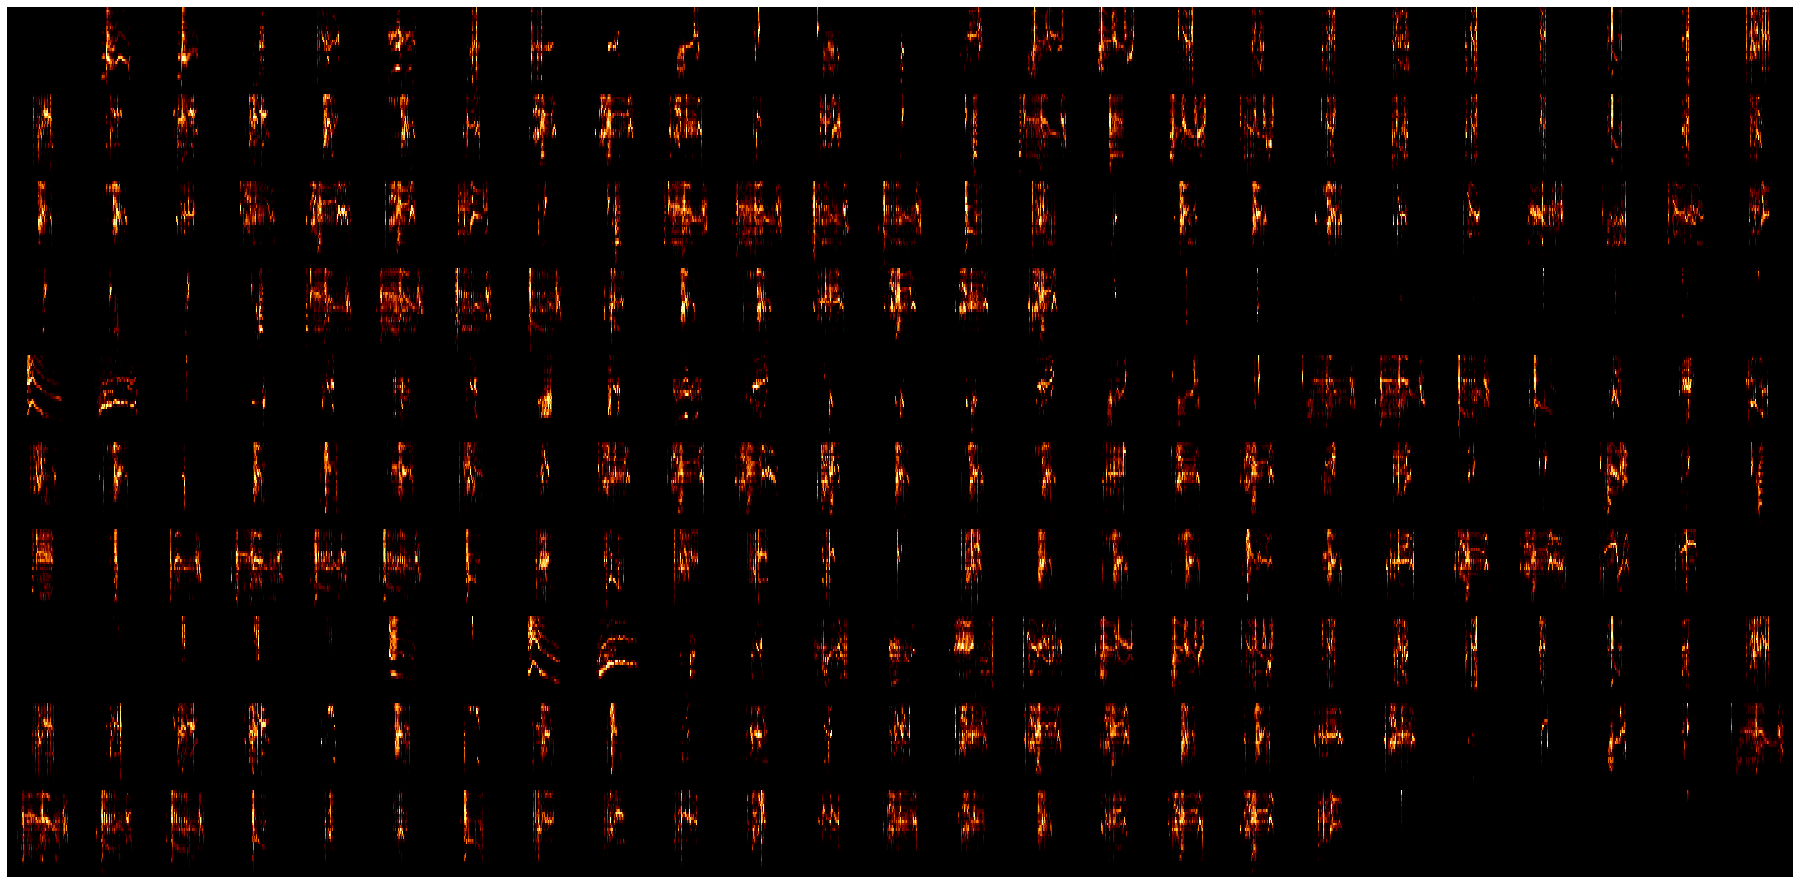

In [30]:
fig, ax = plt.subplots(figsize=(32, 16))

draw_spec_set(list(syl_df['spec_pad']), zoom=20, maxrows=10, colsize=25, ax=ax)

#### cluster spectrograms with hdbscan

Get umap embeddings of all padded

In [31]:
embedding = umap.UMAP(min_dist = 0.5, verbose = True)

specs_flattened = flatten_spectrograms(list(syl_df['spec_pad']))
specs_umap = list(embedding.fit_transform(specs_flattened))
syl_df['umap'] = specs_umap

UMAP(min_dist=0.5, verbose=True)
Fri Aug 25 13:31:03 2023 Construct fuzzy simplicial set
Fri Aug 25 13:32:04 2023 Finding Nearest Neighbors
Fri Aug 25 13:32:06 2023 Finished Nearest Neighbor Search
Fri Aug 25 13:32:08 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Aug 25 13:32:15 2023 Finished embedding


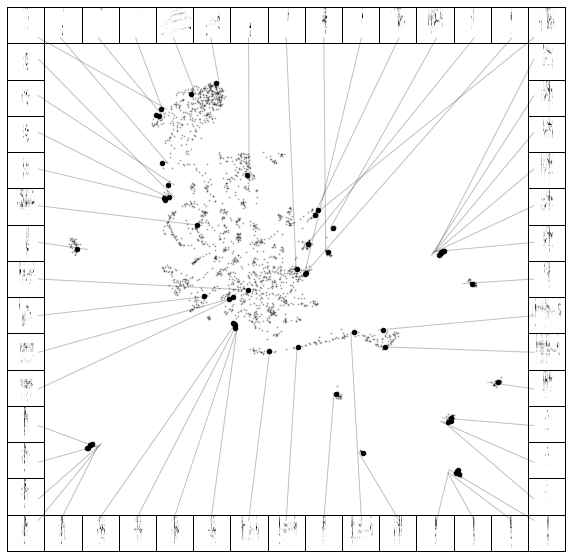

In [32]:
scatter_spec(
        np.vstack(syl_df['umap']),
        list(syl_df['spec_pad']),
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            #'labels': list(indv_df.phrase.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );

plt.show()

cluster all padded

In [33]:
umap_arr = np.vstack(list(syl_df['umap']))

min_cluster_size = int(len(umap_arr) * 0.002) # 0.002
print(min_cluster_size)

4


In [34]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size).fit(umap_arr)

syl_df['hdbscan_labels'] = list(clusterer.labels_)

/mnt/cube/lo/envs/avgn_paper/avgn/visualization/projections.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array([lab_dict[i] for i in labels])


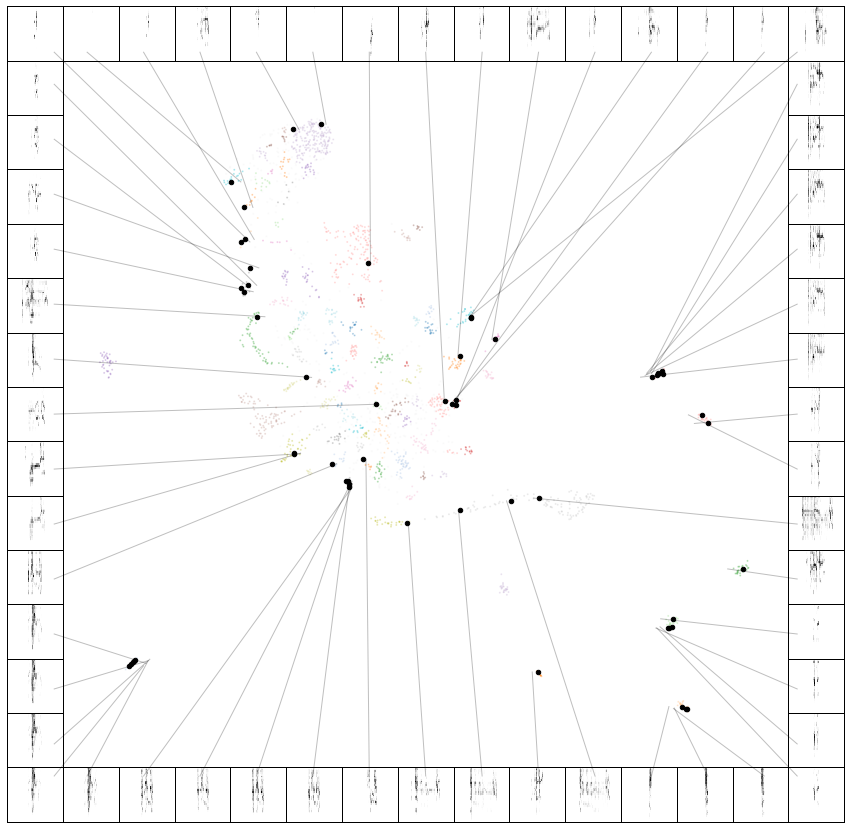

In [35]:
scatter_spec(
        umap_arr,
        list(syl_df['spec_pad']),
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(15, 15),
        scatter_kwargs = {
            'labels': list(syl_df.hdbscan_labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
plt.show()

In [36]:
syl_df.head(1)

syl_idx                                            mic_arr    s_on  \
0     0-0  [2, 3, 11, 4, -1, 13, 32, -8, 15, -4, 18, 11, ...  189640   

   s_on_gpf                                            gpf_arr  \
0       316  [[-0.7721941002898705, -0.654150502280424, -0....   

                                             pre_arr  spk_ms_arr  spk_arr  \
0  [10913, 10921, 10909, 10908, 10926, 10917, 109...         NaN      NaN   

  bout_idx                                               spec  \
0        0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            spec_pad  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             pre_pad  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                             gpf_pad  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                       umap  hdbscan_labels  
0  [-0.93740237, 33.252357]              69

In [37]:
np.unique(syl_df['hdbscan_labels'])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90])

In [38]:
syl_sel = (syl_df['hdbscan_labels']==11)
np.sum(syl_sel==True)

12

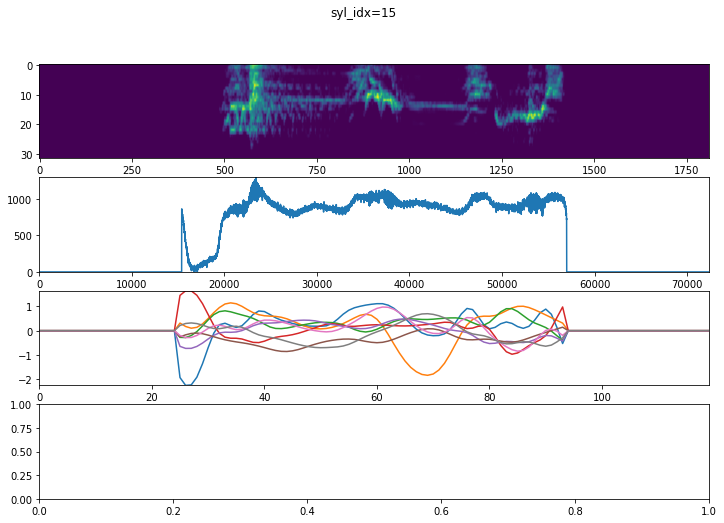

In [39]:
def plot_syl(syl_df, i_syl, spk=False):
    fig, ax = plt.subplots(nrows=4, figsize=(12, 8))
    fig.suptitle('syl_idx={}'.format(i_syl))
    ax[0].imshow(syl_df.iloc[i_syl]['spec_pad'][::-1], aspect='auto')
    ax[1].plot(syl_df.iloc[i_syl]['pre_pad'])
    ax[2].plot(syl_df.iloc[i_syl]['gpf_pad'].T);
    if spk:
        pu.plot_as_raster(syl_df.iloc[i_syl]['spk_pad'], ax[3])
        ax[3].set_xlim(0, syl_df.iloc[i_syl]['spk_pad'].shape[-1])
    return ax, syl_df.iloc[i_syl]

ax, syl_ds = plot_syl(syl_df, 15)

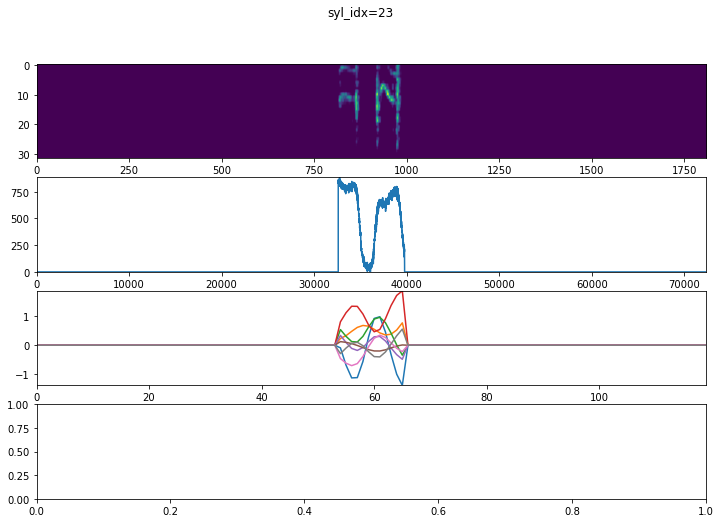

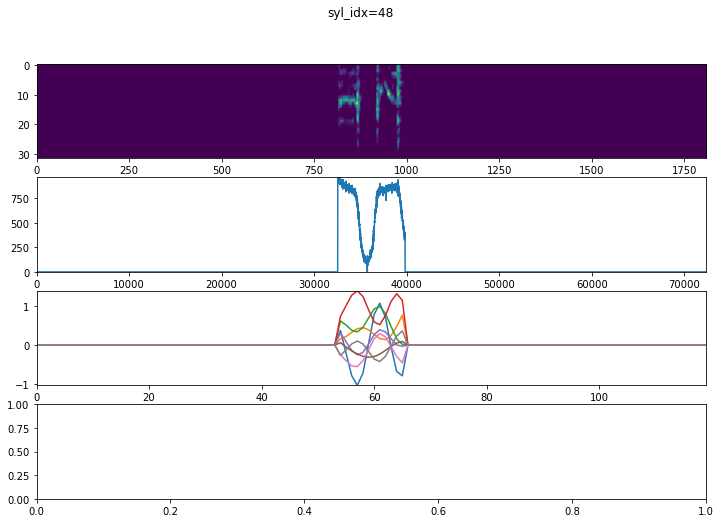

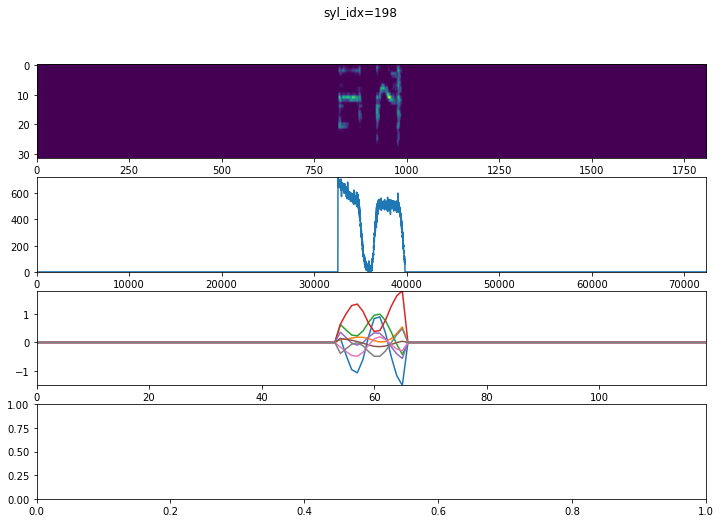

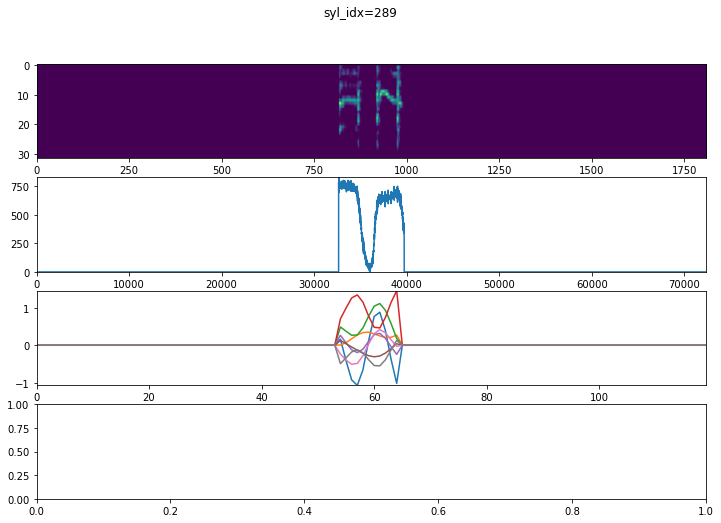

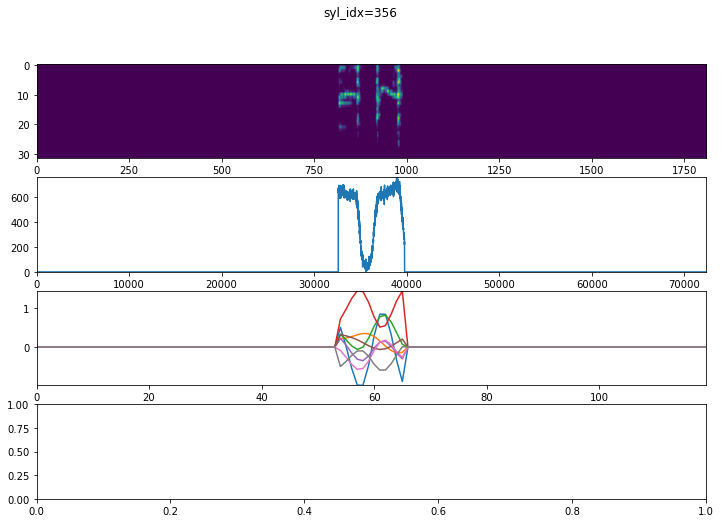

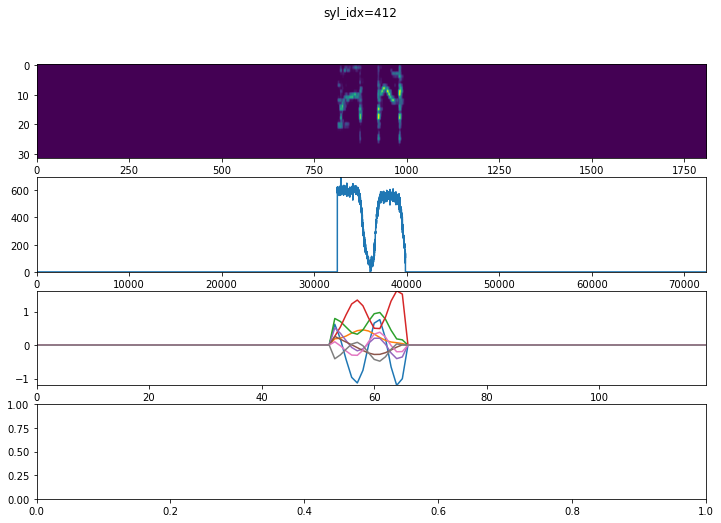

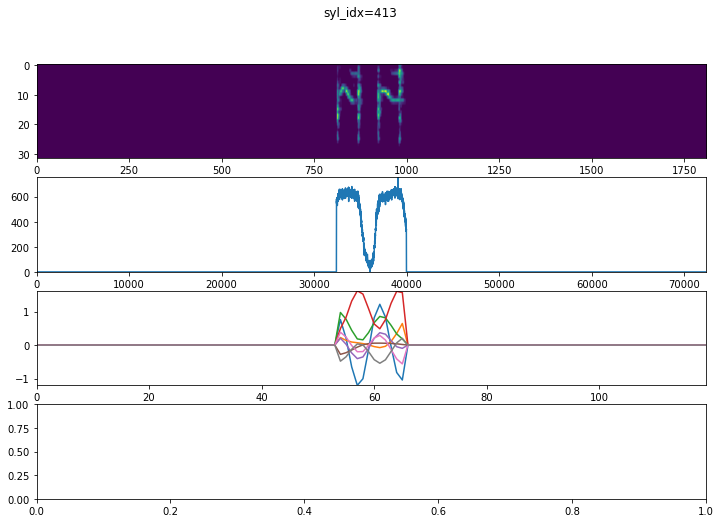

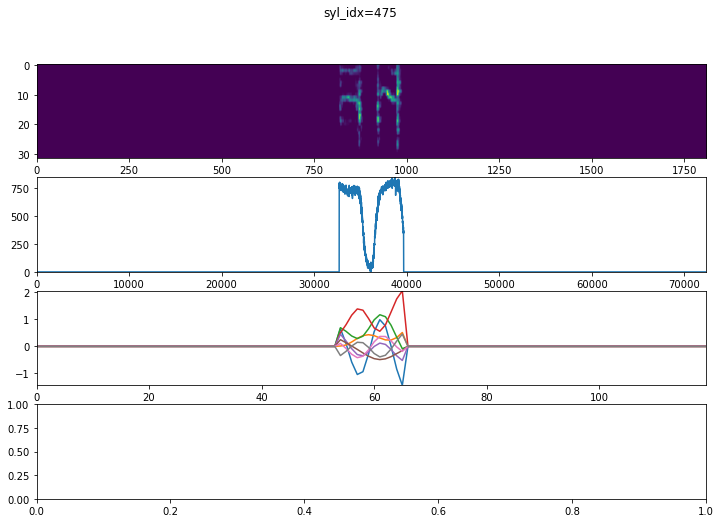

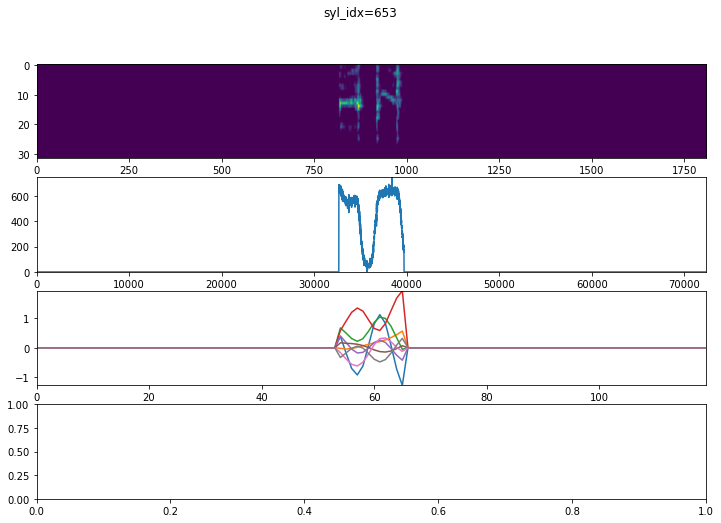

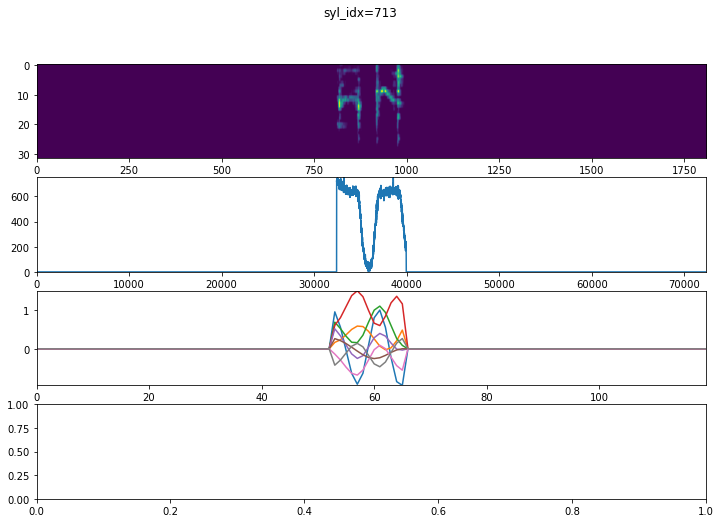

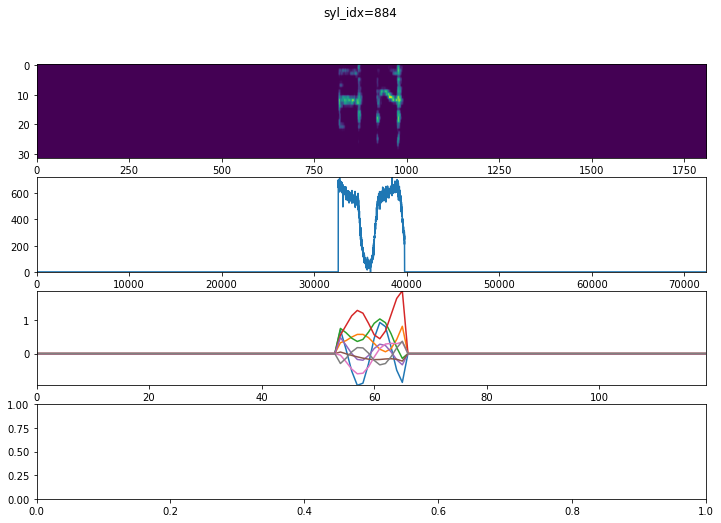

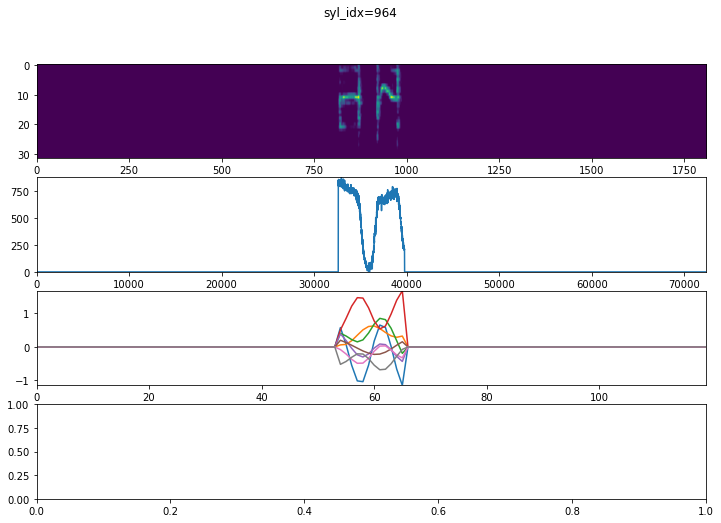

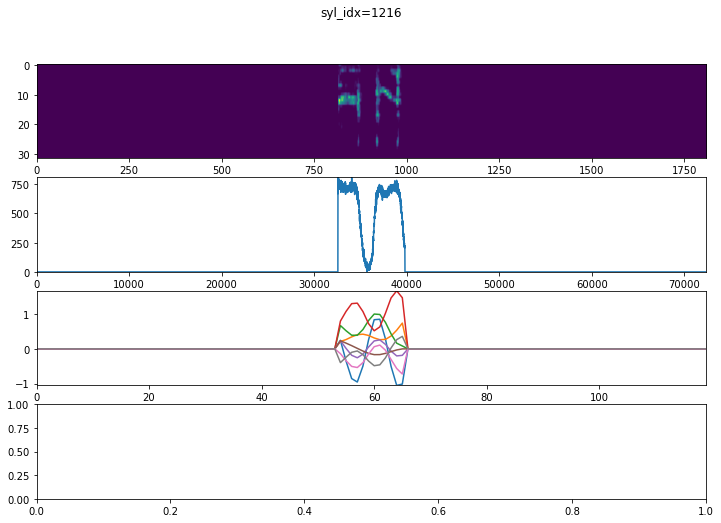

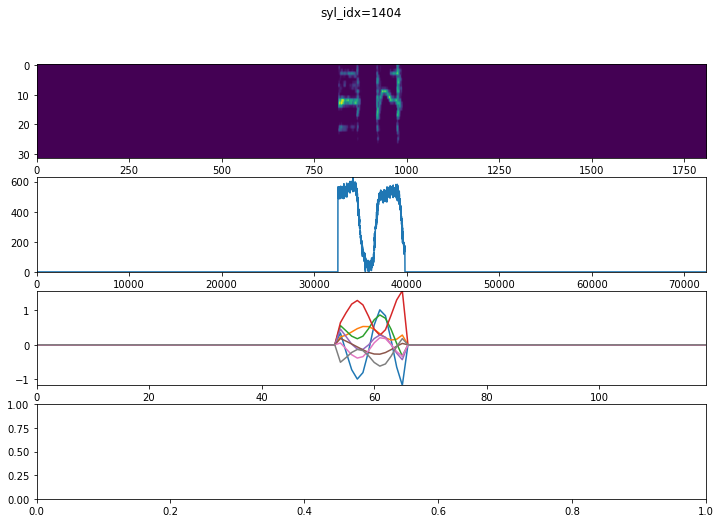

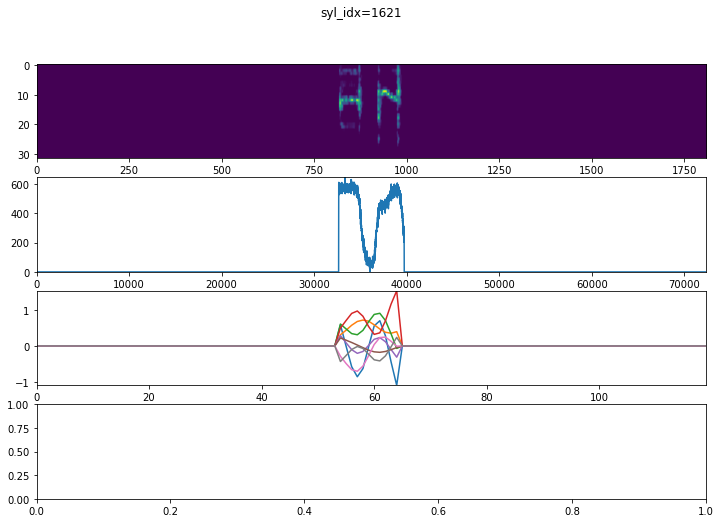

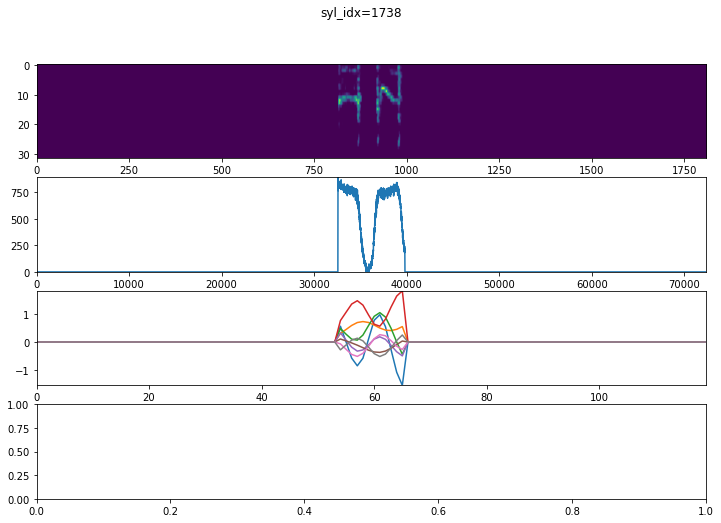

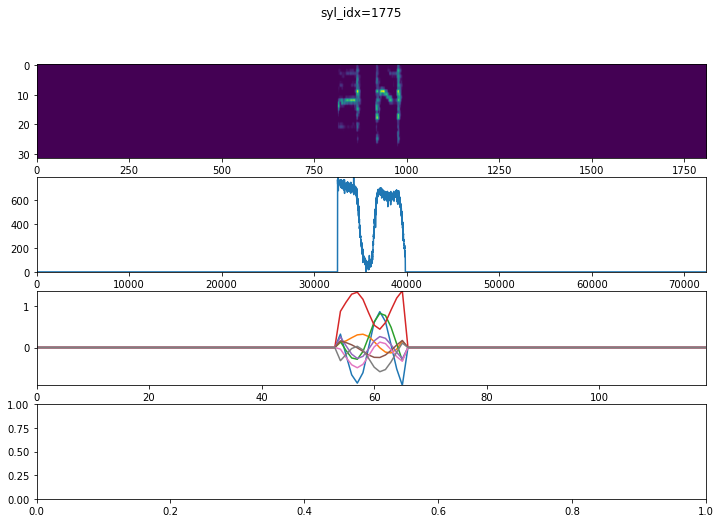

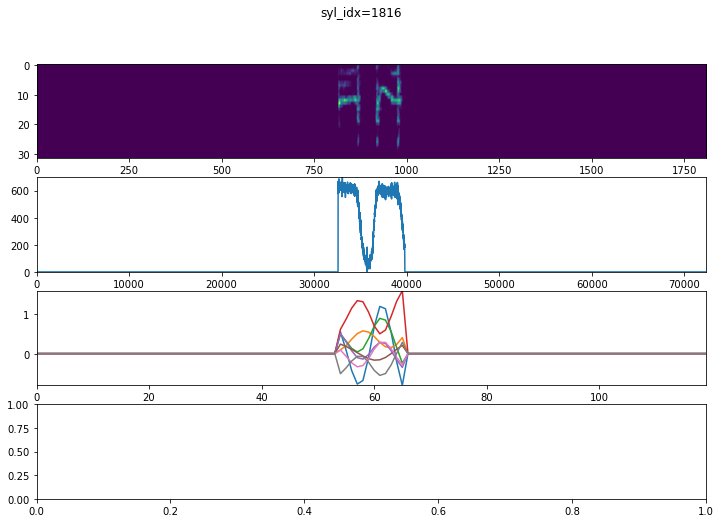

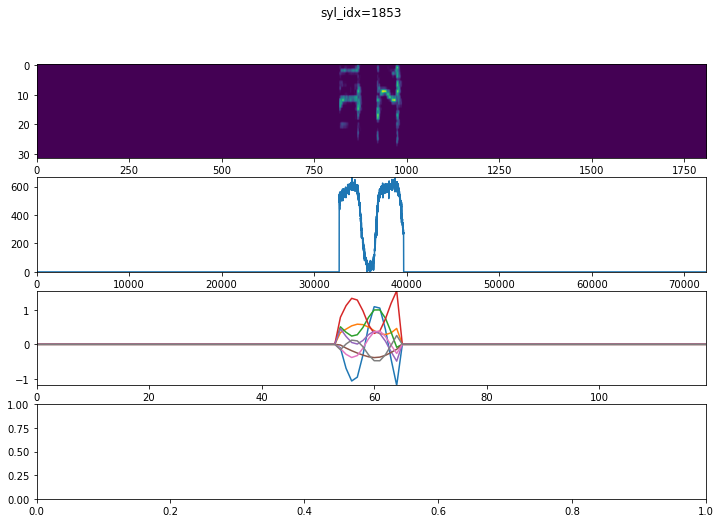

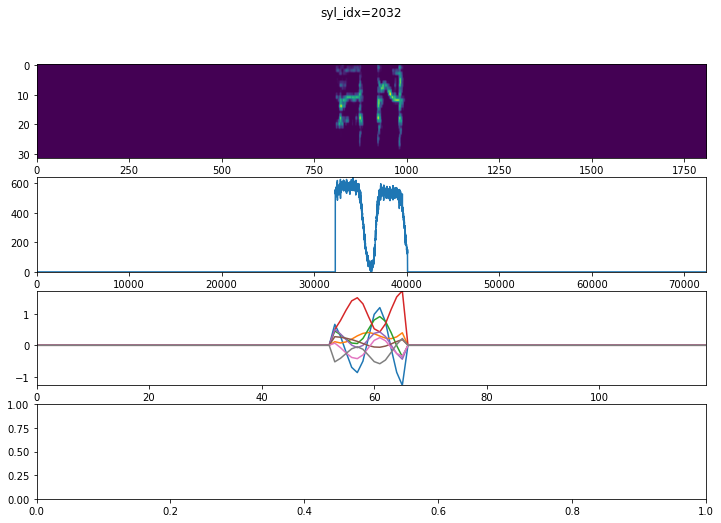

In [41]:
def plot_syl_clu(syl_df, clu):
    syl_sel = (syl_df['hdbscan_labels']==clu)
    
    sel_df = syl_df[syl_sel]
       
    for i_syl, syl_idx in enumerate(sel_df.index):
        ax, syl_ds = plot_syl(syl_df, syl_idx)
#         break
    return sel_df
    
syl_clu_df = plot_syl_clu(syl_df, 2)

/tmp/ipykernel_1066482/3782299528.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=4, figsize=(12, 8))


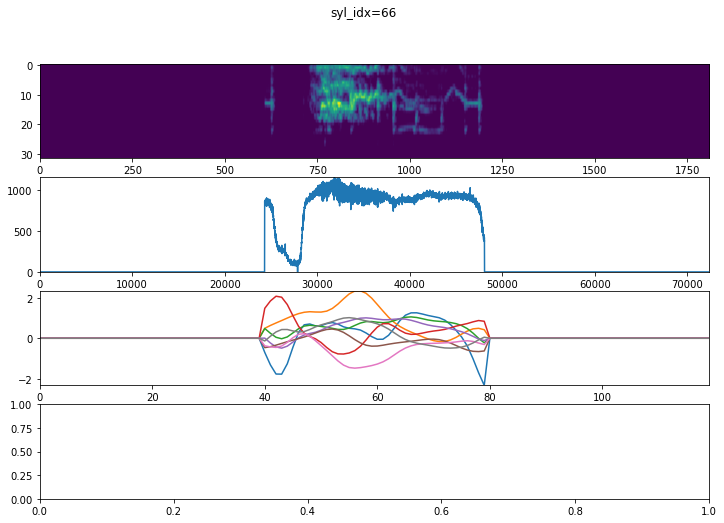

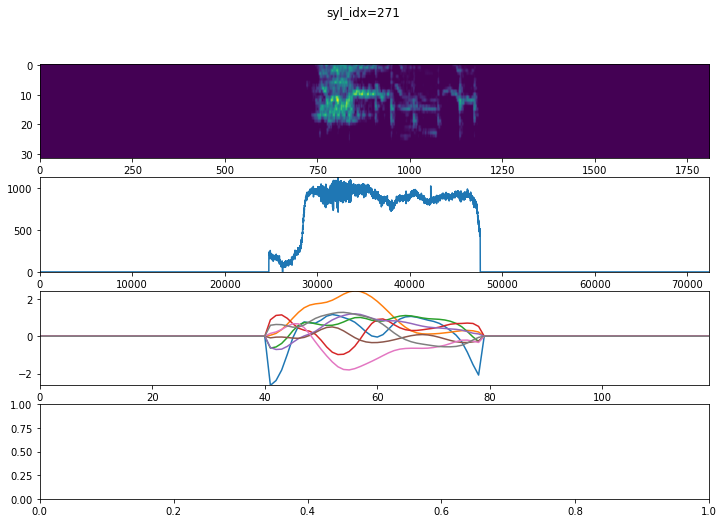

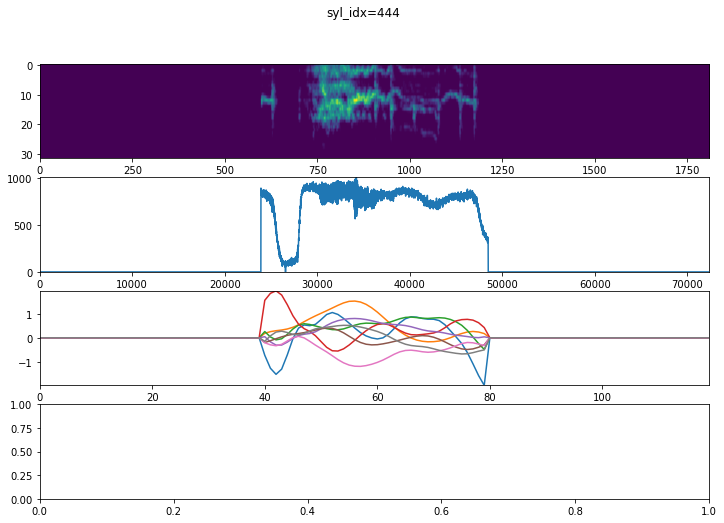

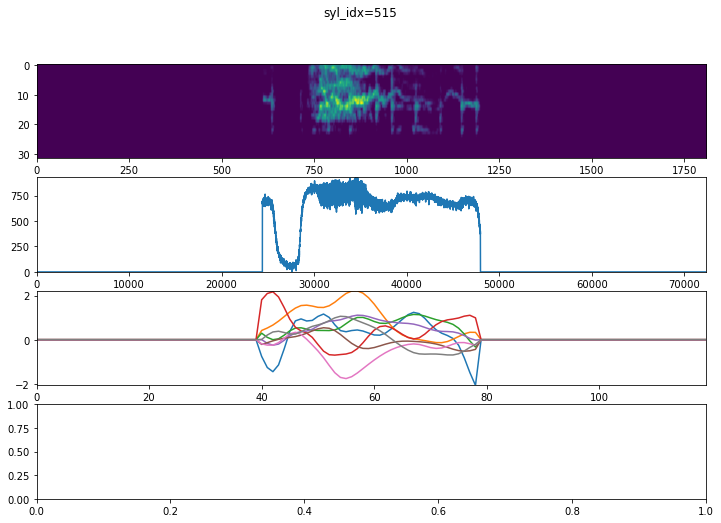

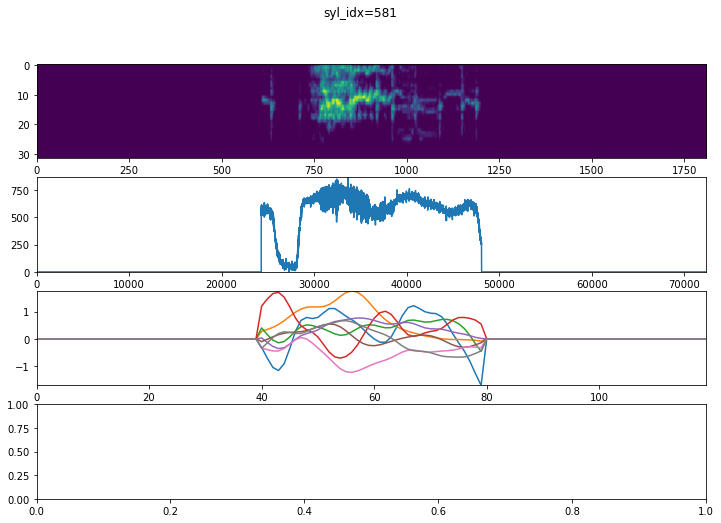

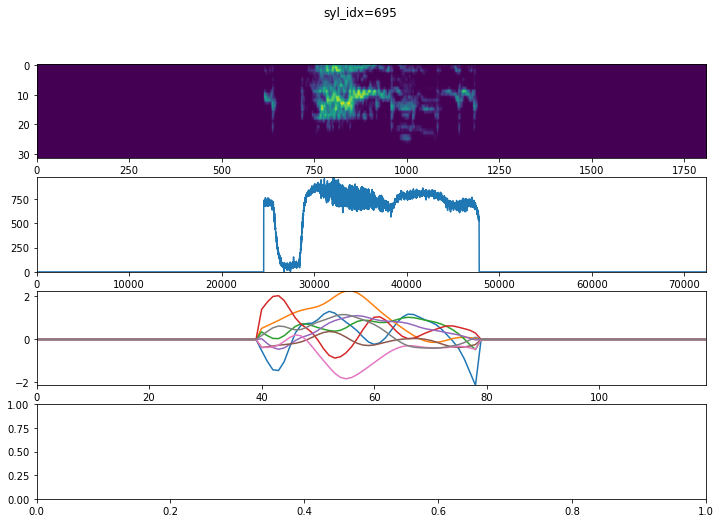

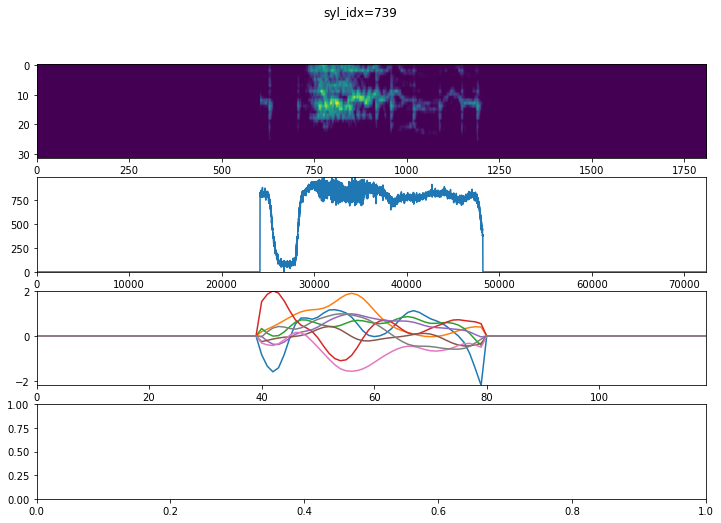

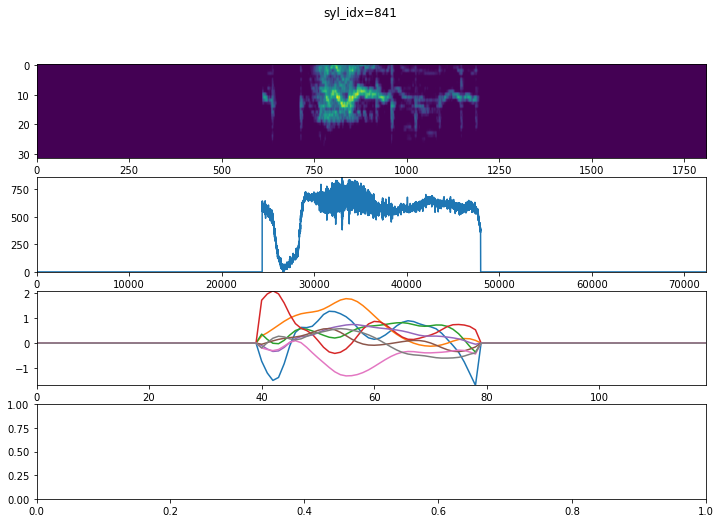

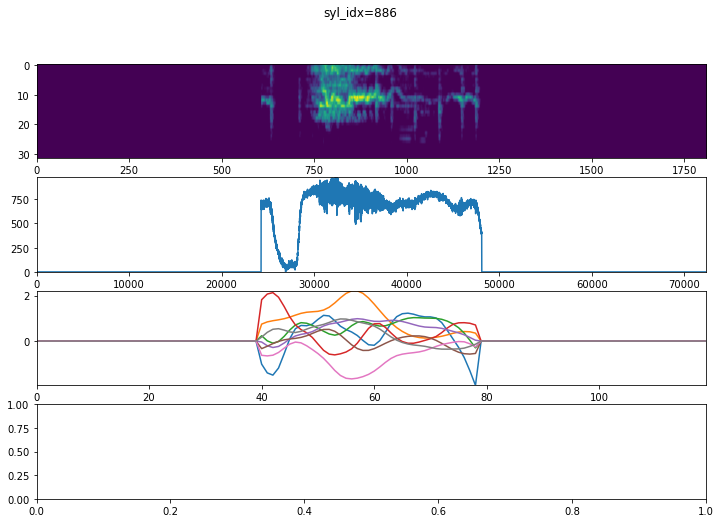

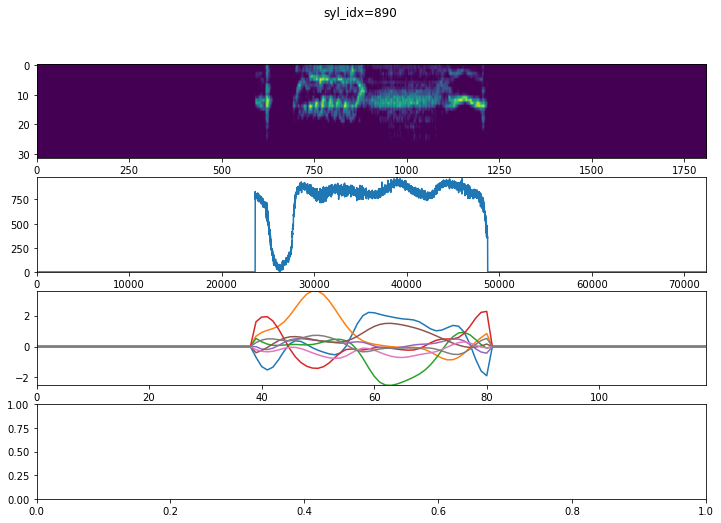

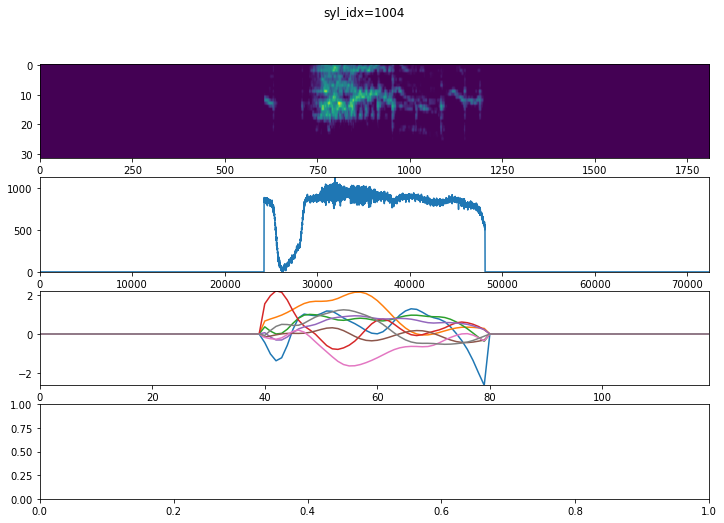

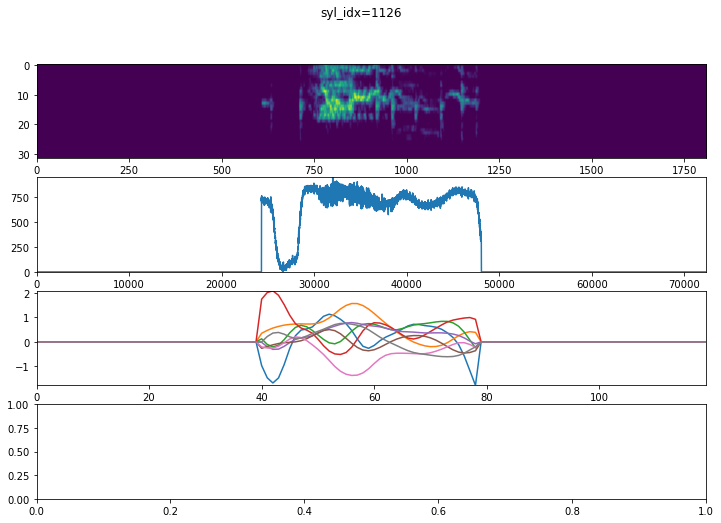

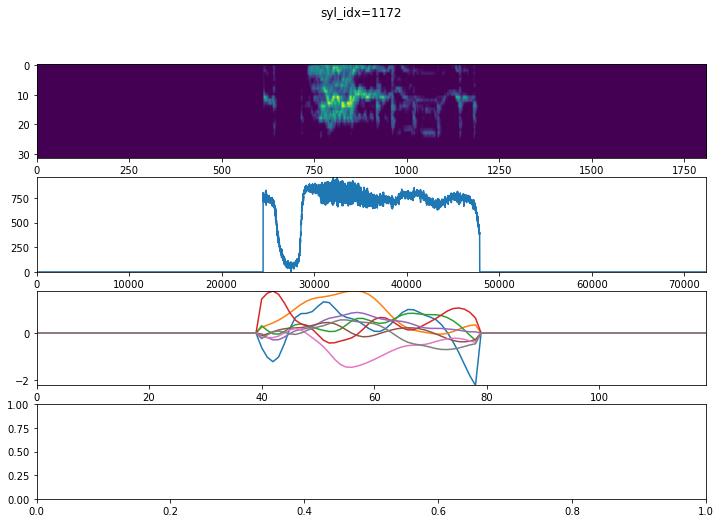

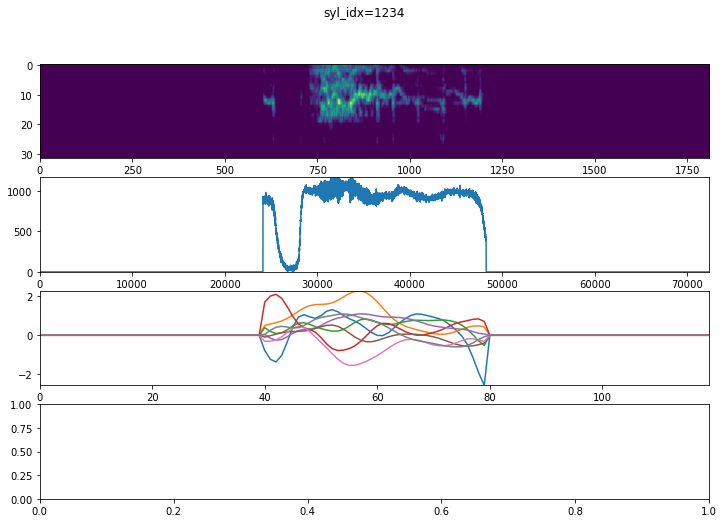

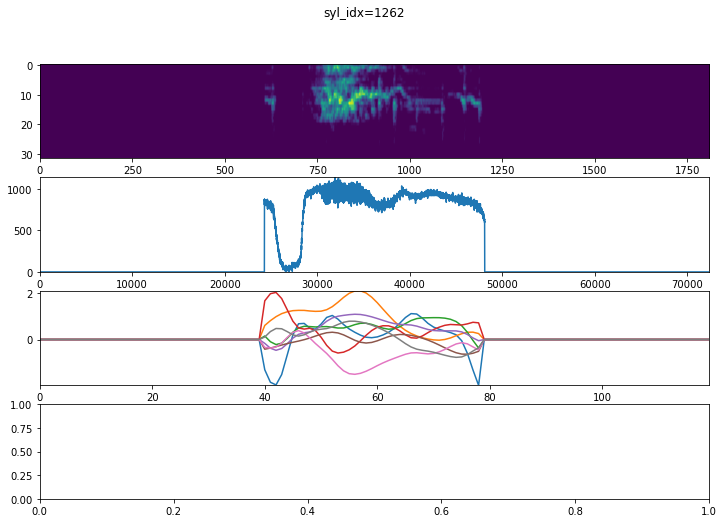

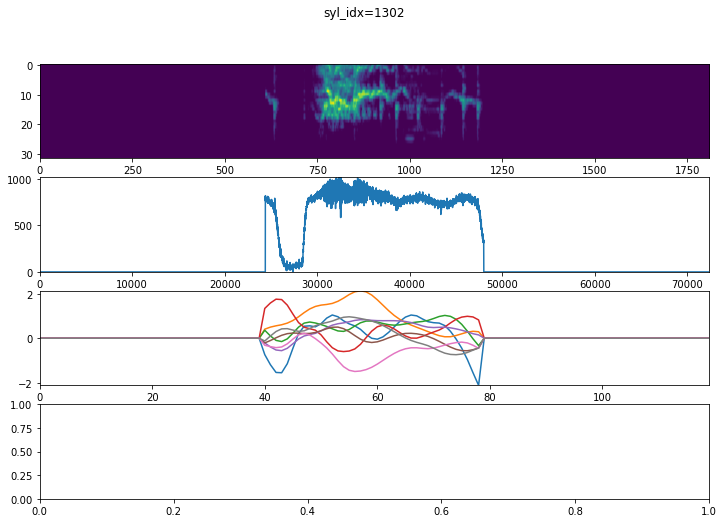

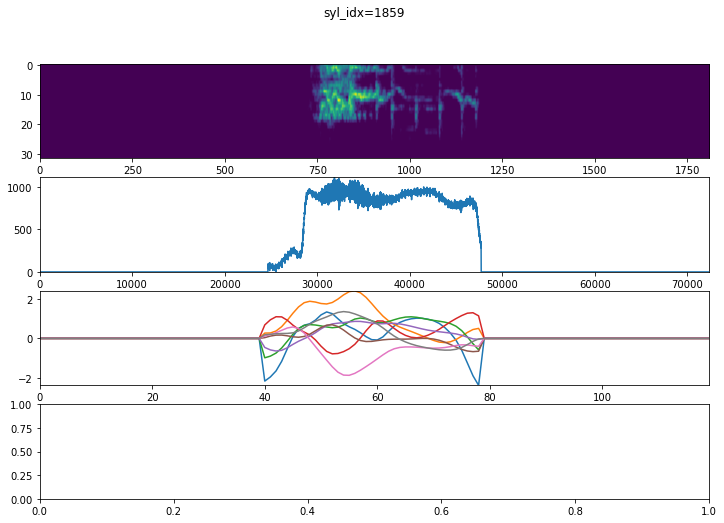

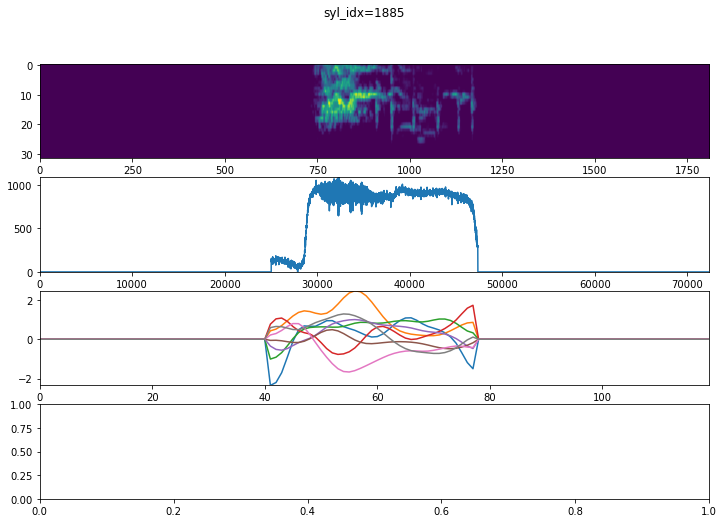

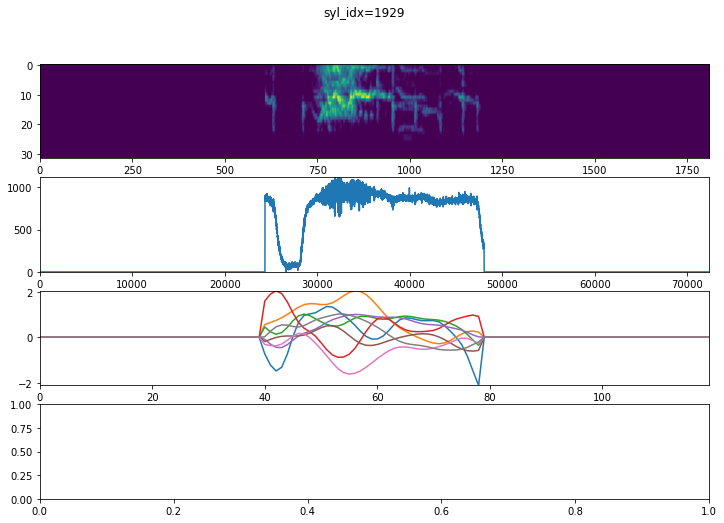

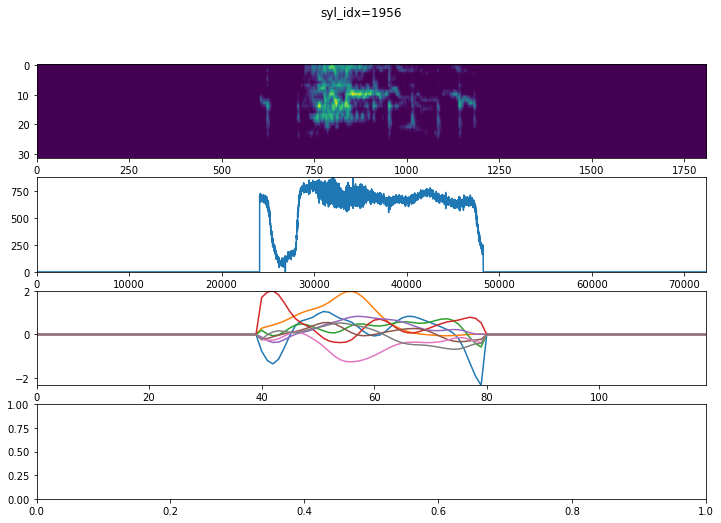

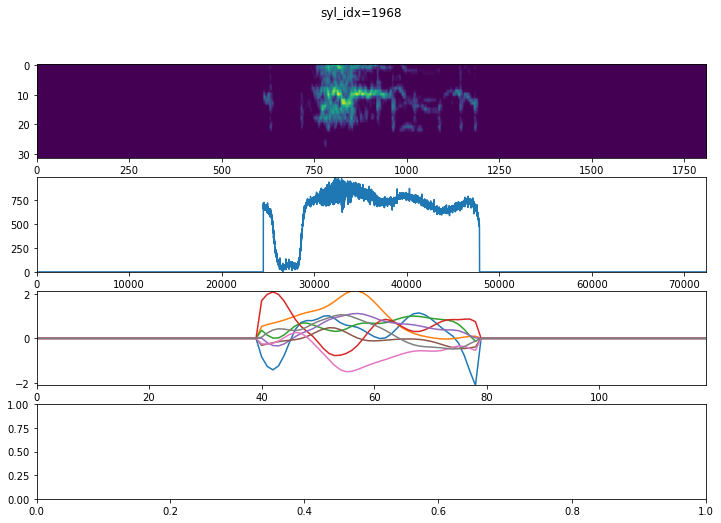

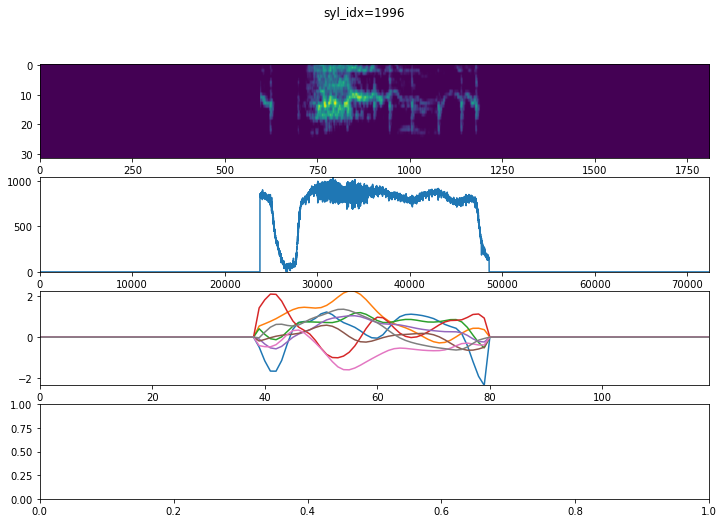

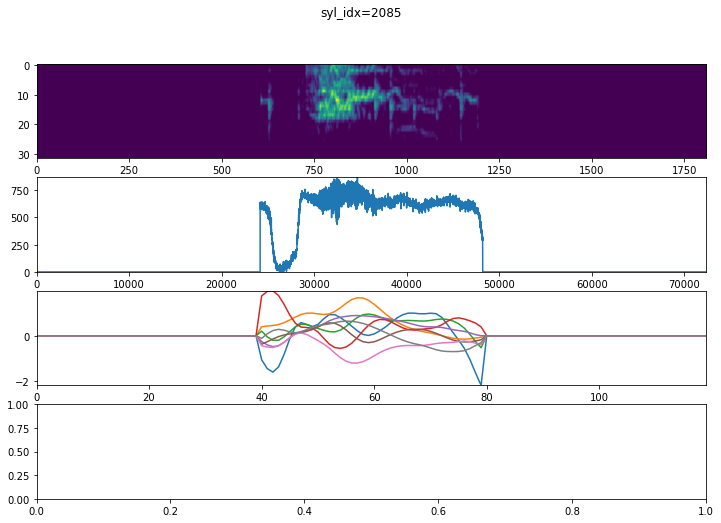

In [42]:
syl_clu_df = plot_syl_clu(syl_df, 10)

In [43]:
syl_df_file = output_path + 'syl_clust_df.pkl'
syl_df_file

'/mnt/cube/tsmcpher/proj/am_pop/data/s_b1555_22/ra_sort_2022-04-29/syl_clust_df.pkl'

In [44]:
with open(syl_df_file, 'wb') as f:
    pickle.dump(syl_df, f)

In [45]:
with open(syl_df_file, 'rb') as f:
    syl_df = pickle.load(f) 

# Continuous bout analysis

In [46]:
bout_df

index                                               f_xx  \
0       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
1       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
2       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
3       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
4       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
5       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
6       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
7       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
8       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
9       0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
10      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
11      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
12      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
13      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
14      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
15      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
16      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
17      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
18      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
19      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
20      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
21      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
22      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
23      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
24      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
25      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
26      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
27      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
28      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
29      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
30      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
31      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
32      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
33      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
34      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
35      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
36      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
37      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
38      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
39      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
40      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
41      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
42      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
43      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
44      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
45      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
46      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
47      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
48      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
49      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
50      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   
51      0  [156.25, 234.375, 312.5, 390.625, 468.75, 546....   

                                              mic_arr  \
0   [-26, -31, -50, -30, -42, -46, -16, -42, -33, ...   
1   [-15, -26, -20, -42, -25, -25, -33, -21, -18, ...   
2   [-27, -13, -4, -7, -9, -21, 3, -18, -14, -8, -...   
3   [81, 270, 265, 378, 501, 348, 348, 270, 80, -8...   
4   [1317, -780, -1293, -185, 885, 1121, 753, 857,...   
5   [-7, 9, -2, 9, 10, 2, -21, -31, 4, -44, 29, 5,...   
6   [335, 180, 291, 140, 68, 95, -148, 51, -5, 83,...   
7   [-18, -6, -16, -1, -22, -27, -12, -31, -16, -2...   
8   [-42, -65, 10, -47, -121, -49, 4, -70, -27, -8...   
9   [13, 12, 19, 20, -4, 27, -11, 6, 24, 

In [47]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_gpf',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx', 's_on', 's_off', 's_on_ap',
       's_off_ap', 'gp_nidq_rate', 'ms_on', 'ms_off'],
      dtype='object')

In [48]:
%%time
tqdm.pandas(desc='making spectrograms')
bout_df['spec'] = bout_df['mic_arr'].progress_apply(lambda x: make_spec(x/32768, bout_dict['s_f'], 
                                                                 hparams=hparams,
                                                                 mel_matrix=mel_matrix,
                                                                 use_mel=True,
                                                                 use_tensorflow=False))

making spectrograms:   0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 2min 8s, sys: 2min 14s, total: 4min 22s
Wall time: 49.1 s


(32, 65781)


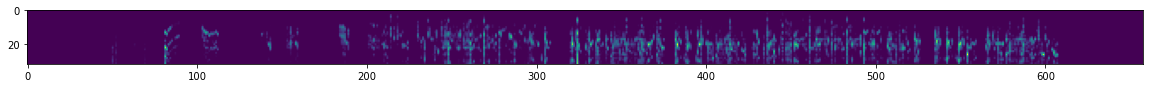

In [49]:
i=11
print(bout_df.spec[1].shape)
plt.figure(figsize=(20,50))
plt.imshow(bout_df.spec[1][:,::100])

(722, 32, 2048)


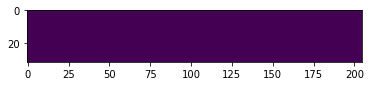

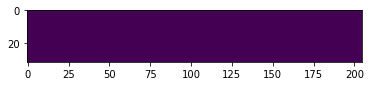

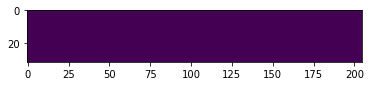

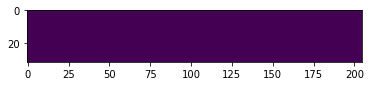

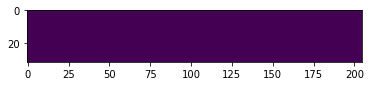

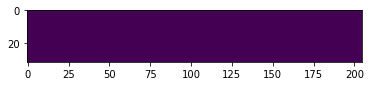

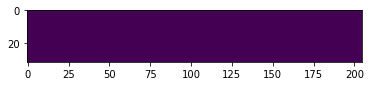

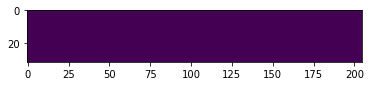

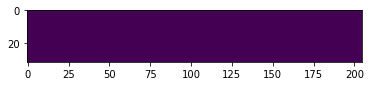

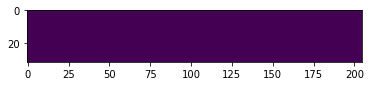

In [50]:
def seg_spec(spec,n_seg_bin,step):
    if n_seg_bin is not None:
        segs = [spec[:, n:(n+n_seg_bin)] for n in np.arange(0,len(spec.T)-n_seg_bin,step)]
    return np.array(segs)

n_seg_bin = 2048
step = 64
n_seg_plot = 10

test_segs = seg_spec(bout_df.spec[11],n_seg_bin,step)
print(test_segs.shape)
for plt_i in range(n_seg_plot):
    plt.figure()
    plt.imshow(test_segs[plt_i,:,::10])

In [51]:
n_seg_bin_list = [32,64,128,256]
step_list = [2,4,8,16]

In [52]:
%%time
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

for seg_bin_i in range(len(n_seg_bin_list)):
    this_n_seg_bin = n_seg_bin_list[seg_bin_i]
    this_step = step_list[seg_bin_i]
    spec_seg_str = 'spec_seg_' + str(this_n_seg_bin)
    print(spec_seg_str)
    bout_df[spec_seg_str] = bout_df['spec'].progress_apply(lambda x: seg_spec(x,this_n_seg_bin,this_step))
    bout_df[spec_seg_str] = bout_df[spec_seg_str].apply(lambda x: (norm(x)*255).astype('uint8'))

spec_seg_32


making spectrograms:   0%|          | 0/52 [00:00<?, ?it/s]

spec_seg_64


making spectrograms:   0%|          | 0/52 [00:00<?, ?it/s]

spec_seg_128


making spectrograms:   0%|          | 0/52 [00:00<?, ?it/s]

spec_seg_256


making spectrograms:   0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 18 s, sys: 6.32 s, total: 24.3 s
Wall time: 24.3 s


In [53]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_gpf',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx', 's_on', 's_off', 's_on_ap',
       's_off_ap', 'gp_nidq_rate', 'ms_on', 'ms_off', 'spec', 'spec_seg_32',
       'spec_seg_64', 'spec_seg_128', 'spec_seg_256'],
      dtype='object')

In [54]:
%%time
for seg_bin_i in tqdm(range(len(n_seg_bin_list))):
    this_n_seg_bin = n_seg_bin_list[seg_bin_i]
    spec_seg_str = 'spec_seg_' + str(this_n_seg_bin)
    print(spec_seg_str)
    
    embedding = umap.UMAP(min_dist = 0.5, verbose = True)
    
    specs_flat_all = []
    for bout_i in range(len(bout_df)):
        specs_flattened = flatten_spectrograms(list(bout_df[spec_seg_str][bout_i]))
        specs_flat_all.append(specs_flattened)
    specs_flat_all_cat = np.concatenate(specs_flat_all)
    specs_umap = list(embedding.fit_transform(specs_flat_all_cat))

    bout_n_segs = [specs_flat_all[i].shape[0] for i in range(len(bout_df))]
    bout_umap = []
    seg_count = 0
    for bout_i in range(len(bout_df)):
        this_bout_n_segs = bout_n_segs[bout_i]
        bout_umap.append(specs_umap[seg_count:seg_count+this_bout_n_segs])
        seg_count = seg_count + this_bout_n_segs
    
    bout_df['umap_seg_' + str(this_n_seg_bin)] = bout_umap

  0%|          | 0/4 [00:00<?, ?it/s]

spec_seg_32
UMAP(min_dist=0.5, verbose=True)
Fri Apr 14 18:39:57 2023 Construct fuzzy simplicial set
Fri Apr 14 18:39:58 2023 Finding Nearest Neighbors
Fri Apr 14 18:39:59 2023 Building RP forest with 54 trees
Fri Apr 14 18:40:52 2023 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	 6  /  20
	Stopping threshold met -- exiting after 6 iterations
Fri Apr 14 18:42:13 2023 Finished Nearest Neighbor Search
Fri Apr 14 18:42:21 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Apr 14 18:57:17 2023 Finished embedding
spec_seg_64
UMAP(min_dist=0.5, verbose=True)
Fri Apr 14 18:57:36 2023 Construct fuzzy simplicial set
Fri Apr 14 18:57:38 2023 Finding Nearest Neighbors
Fri Apr 14 18:57:38 2023 Building RP forest with 40 trees
Fri Apr 14 18:58:19 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	Stopping threshold met -- exiting after 7 iterations
Fri Apr 14 18:58:54 2023 Finished Nearest Neighbor Search
Fri Apr 14 18:58:58 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Apr 14 19:05:15 2023 Finished embedding
spec_seg_128
UMAP(min_dist=0.5, verbose=True)
Fri Apr 14 19:05:29 2023 Construct fuzzy simplicial set
Fri Apr 14 19:05:30 2023 Finding Nearest Neighbors
Fri Apr 14 19:05:30 2023 Building RP forest with 30 trees
Fri Apr 14 19:06:00 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	Stopping threshold met -- exiting after 7 iterations
Fri Apr 14 19:06:19 2023 Finished Nearest Neighbor Search
Fri Apr 14 19:06:21 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Apr 14 19:09:38 2023 Finished embedding
spec_seg_256
UMAP(min_dist=0.5, verbose=True)
Fri Apr 14 19:09:48 2023 Construct fuzzy simplicial set
Fri Apr 14 19:09:49 2023 Finding Nearest Neighbors
Fri Apr 14 19:09:50 2023 Building RP forest with 22 trees
Fri Apr 14 19:10:13 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	Stopping threshold met -- exiting after 8 iterations
Fri Apr 14 19:10:25 2023 Finished Nearest Neighbor Search
Fri Apr 14 19:10:26 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Apr 14 19:11:56 2023 Finished embedding
CPU times: user 11h 51min 52s, sys: 1h 25min 9s, total: 13h 17min 1s
Wall time: 32min 9s


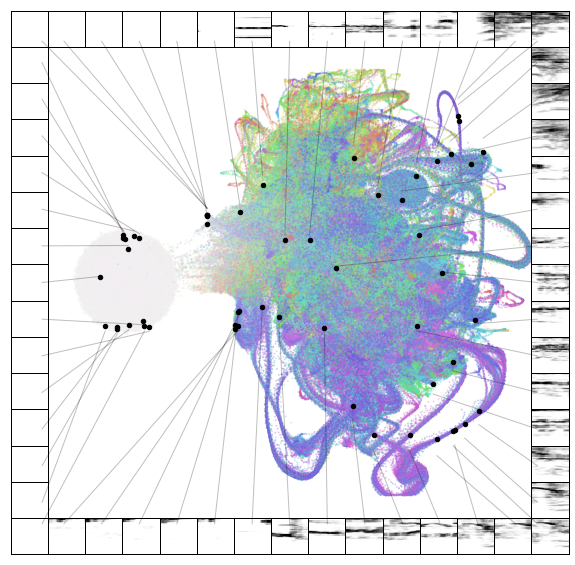

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


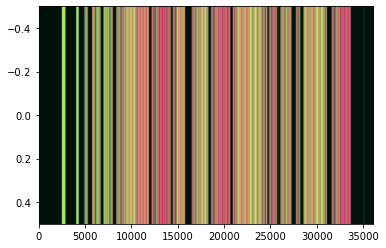

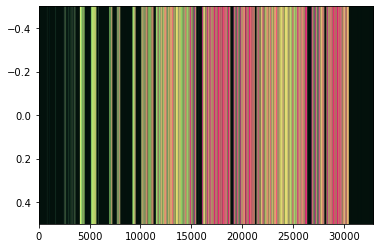

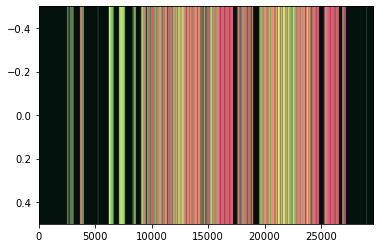

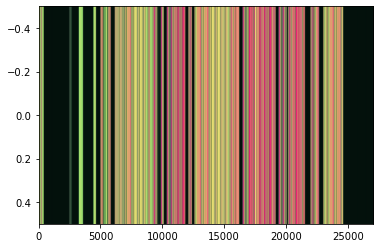

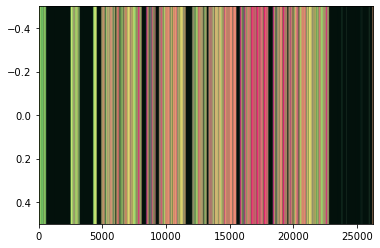

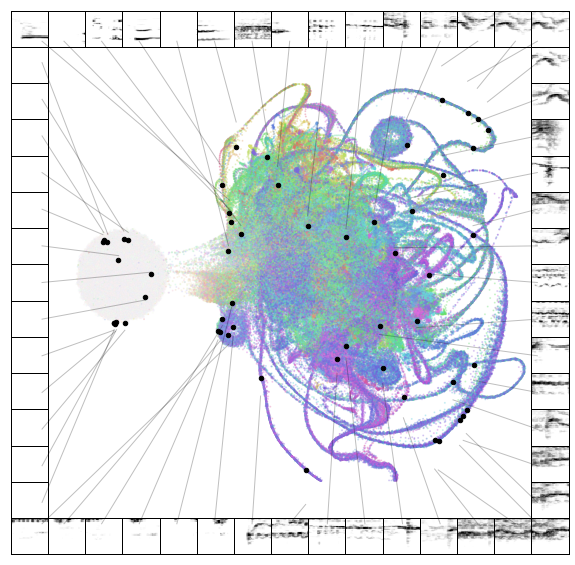

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
for seg_i in range(len(n_seg_bin_list)):
    this_n_seg_bin = n_seg_bin_list[seg_i]
    umap_seg_str = 'umap_seg_' + str(this_n_seg_bin)
    spec_seg_str = 'spec_seg_' + str(this_n_seg_bin)
    
    umap_data = np.vstack(bout_df[umap_seg_str])
    spec_data = np.vstack(bout_df[spec_seg_str])

    cols = []
    mask = []
    for bout_i in range(len(bout_df)):
        cols.append(np.array(sns.color_palette('hls',len(bout_df[umap_seg_str][bout_i]))))
        specs_flattened = flatten_spectrograms(list(bout_df[spec_seg_str][bout_i]))
        mask.append(np.expand_dims((norm(np.max(specs_flattened,axis=1)) + 1e-5)**.2,1))
    cols_cat = np.concatenate(cols)
    mask_cat = np.concatenate(mask)
    cols_cat = 1-((1-cols_cat) * mask_cat)
    
    bout_df['mask_' + str(this_n_seg_bin)] = mask
    bout_df['cols_' + str(this_n_seg_bin)] = cols

    scatter_spec(
            umap_data,
            spec_data,
            column_size=15,
            #x_range = [-5.5,7],
            #y_range = [-10,10],
            pal_color="hls",
            color_points=False,
            enlarge_points=20,
            figsize=(10, 10),
            scatter_kwargs = {
                'labels': cols_cat,
                'alpha':0.25,
                's': 1,
                'show_legend': False,
                'categorical_labels':False
            },
            matshow_kwargs = {
                'cmap': plt.cm.Greys
            },
            line_kwargs = {
                'lw':1,
                'ls':"solid",
                'alpha':0.25,
            },
            draw_lines=True
        );
    plt.show()
    
    z_normed = copy.deepcopy(umap_data)
    z_normed[z_normed > 10] = 10
    z_normed[z_normed < -10] = -10
    z_normed[:,0] = norm(z_normed[:,0])
    z_normed[:,1] = norm(z_normed[:,1])

    seg_count = 0
    rgb_imgs = []
    for bout_i in range(len(bout_df)):
        this_bout_n_segs = len(bout_df[umap_seg_str][bout_i])
        window_z = z_normed[seg_count:seg_count + this_bout_n_segs]    
        R = norm(window_z[:,0])
        G = norm(window_z[:,1])
        B = np.ones_like(G)*.5
        RGB = np.dstack((R,G,B))
        RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
        rgb_img = np.expand_dims(RGB,0)
        rgb_imgs.append(rgb_img)
        seg_count += this_bout_n_segs
        
    bout_df['rbg_' + str(this_n_seg_bin)] = rgb_imgs
        
    for bout_i in range(len(bout_df[:5])):
        bout_mask = mask[bout_i]
        rgb_img = ((rgb_imgs[bout_i]) * bout_mask)
        plt.figure()
        plt.imshow(rgb_img, interpolation=None, aspect='auto')

In [ ]:
hdbscan_labels_all_bout = []
for bout_i in range(len(bout_df)):
    this_bout_hdbscan_labels = syl_df[syl_df.bout_idx == str(bout_i)].hdbscan_labels
    # instance where initial syllables dropped bc they start at 0 or at an earlier sample
    if len(this_bout_hdbscan_labels) < len(bout_df['s_on'].iloc[bout_i]):
        bout_df['s_on'].iloc[bout_i] = bout_df['s_on'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
        bout_df['s_off'].iloc[bout_i] = bout_df['s_off'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
        bout_df['s_on_ap'].iloc[bout_i] = bout_df['s_on_ap'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
        bout_df['s_off_ap'].iloc[bout_i] = bout_df['s_off_ap'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
        bout_df['ms_on'].iloc[bout_i] = bout_df['ms_on'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
        bout_df['ms_off'].iloc[bout_i] = bout_df['ms_off'].iloc[bout_i][-len(this_bout_hdbscan_labels):]
    hdbscan_labels_all_bout.append(this_bout_hdbscan_labels)  
bout_df['syl_hdbscan_labels'] = hdbscan_labels_all_bout

In [ ]:
bout_df.keys()

In [ ]:
bout_df_file = output_path + 'bout_umap_df.pkl'
bout_df_file

In [ ]:
with open(bout_df_file, 'wb') as f:
    pickle.dump(bout_df, f)

In [ ]:
with open(bout_df_file, 'rb') as f:
    bout_df = pickle.load(f) 